In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.nn.utils import clip_grad_norm_

In [4]:
## data from all the datasets, combine together

import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.nn.utils import clip_grad_norm_
db = {}
db[1] = pd.read_csv('/home/azureuser/cloudfiles/code/Users/Ligang.Lu/ASD/Data/ASD data with calculated Zero/Sand_SN109_Data Export_2020.csv')
db[2] = pd.read_csv('/home/azureuser/cloudfiles/code/Users/Ligang.Lu/ASD/Data/ASD data with calculated Zero/Sand_MB06_Data Export_2017.csv')
db[3] = pd.read_csv('/home/azureuser/cloudfiles/code/Users/Ligang.Lu/ASD/Data/ASD data with calculated Zero/Sand_MB06_Data Export_2019.csv')
db[4] = pd.read_csv('/home/azureuser/cloudfiles/code/Users/Ligang.Lu/ASD/Data/ASD data with calculated Zero/Sand_MB22_Data Export_2019.csv')
db[5] = pd.read_csv('/home/azureuser/cloudfiles/code/Users/Ligang.Lu/ASD/Data/ASD data with calculated Zero/Sand_MB22_Data Export_2020.csv')
ASD_signal = {}
Bottom_hole_pre = {}
Bottom_hole_temp = {}
Time = {}
for i in range(5):    
    ASD_signal[1] = db[1]["ASD Signal"] 
    ASD_signal[2] = db[2]["ASD Signal"]## sand event at 2200
    ASD_signal[3] = db[3]["ASD Signal"] 
    ASD_signal[4] = db[4]["ASD Signal"]
    ASD_signal[5] = db[5]["ASD Signal"] 

Bottom_hole_pre[1] = db[1]["Bottom Hole Pressure"] 
Bottom_hole_pre[2] = db[2]["Bottomhole Pressure"]
Bottom_hole_pre[3] = db[3]["Bottomhole Pressure"] 
Bottom_hole_pre[4] = db[4]["Bottomhole Pressure"]
Bottom_hole_pre[5] = db[5]["Bottomhole Pressure"] 

Bottom_hole_temp[1] = db[1]["Bottom Hole Temperature"]
Bottom_hole_temp[2] = db[2]["Bottomhole Temperature"]
Bottom_hole_temp[3] = db[3]["Bottomhole Temperature"]
Bottom_hole_temp[4] = db[4]["Bottomhole Temperature"]
Bottom_hole_temp[5] = db[5]["Bottomhole Temperature"]

Time[1] = db[1]["Unnamed: 0"]
Time[2] = db[2]["Unnamed: 0"]
Time[3] = db[3]["Unnamed: 0"]
Time[4] = db[4]["Unnamed: 0"]
Time[5] = db[5]["Unnamed: 0"]

**data pre-processing**

In [3]:
contents = np.load("/home/azureuser/cloudfiles/code/Users/Jianzhe.Lin/phase2_example.npy", allow_pickle=True)
contents

array({0: {'label': [1, 0], 'point_value': array([[0.],
       [1.]]), 'pre_value': array([[0.],
       [1.]]), 'temp_value': array([[0.],
       [1.]])}, 1: {'label': [1, 0], 'point_value': array([[1.],
       [0.]]), 'pre_value': array([[0.],
       [1.]]), 'temp_value': array([[1.],
       [0.]])}, 2: {'label': [1, 0], 'point_value': array([[0.],
       [0.]]), 'pre_value': array([[0.],
       [1.]]), 'temp_value': array([[1.],
       [0.]])}, 3: {'label': [1, 0], 'point_value': array([[1.],
       [0.]]), 'pre_value': array([[0.],
       [1.]]), 'temp_value': array([[0.],
       [1.]])}}, dtype=object)

In [5]:
##data for classification
## 10 secs is one data point, as the data is huge, here we choose data every 12 mins (72)
## if time range covers sand event, positive; else, negative
data_point = {}
num = 0
for data_num in range(1, 6):
    for i in range(0, len(Time[data_num])-8640, 72):
        temp = []
        for j in range(i, i+8640, 72):
            temp.append(ASD_signal[data_num][j])
        if 0 in temp:
            continue  
        data_point[num] = {}
        data_point[num]['label'] = [1, 0]
        for j in range(0, 8640):
            if data_num == 1:
                list_of_date = ['2020-04-08', '2020-06-22', '2020-10-25', '2020-11-20']
            elif data_num == 2:
                list_of_date = ['2017-01-10', '2017-03-05', '2017-4-26', '2017-05-18', '2017-10-31', '2017-11-14']
            elif data_num == 3:
                list_of_date = ['2019-12-26']            
            elif data_num == 4:
                list_of_date = ['2019-08-14', '2019-11-28']
            elif data_num == 5:
                list_of_date = ['2020-11-12']
            if i + j + 8640 < len(Time[data_num]) and str(Time[data_num][i+8640+j])[0:10] in ['2020-04-08', '2020-06-22', '2020-10-25', '2020-11-20']:
                data_point[num]['label'] = [0, 1]
                break
        data_point[num]['point_value'] = []
        data_point[num]['pre_value'] = []
        data_point[num]['temp_value'] = []    

        for j in range(i, i+8640, 72):
            if np.isnan(Bottom_hole_temp[data_num][j]):
                data_point[num]['temp_value'].append(Bottom_hole_temp[data_num][0]) 
            else:
                data_point[num]['temp_value'].append(Bottom_hole_temp[data_num][j])  
            if np.isnan(ASD_signal[data_num][j]):
                data_point[num]['point_value'].append(ASD_signal[data_num][0])
            else:
                data_point[num]['point_value'].append(ASD_signal[data_num][j])
            if np.isnan(Bottom_hole_pre[data_num][j]):
                data_point[num]['pre_value'].append(Bottom_hole_pre[data_num][0])    
            else:
                data_point[num]['pre_value'].append(Bottom_hole_pre[data_num][j])   
        num += 1 
    print(num) 
print(len(data_point[num-1]['point_value']))  
num_pos = 0
num_neg = 0
for i in range(0, num-1):
    if data_point[i]['label'] == [0, 1]:
        num_pos += 1
    else:
        num_neg += 1
print(num_pos)
print(num_neg)

np.save("/home/azureuser/cloudfiles/code/Users/Jianzhe.Lin/phase2_data_CNN.npy", data_point)

43829
88739


Bad pipe message: %s [b"/}n\xb4b\xb9.w\x90lA\xcd\t\x98\xa5\x8a5\x95\x00\x00\xf4\xc00\xc0,\xc0(\xc0$\xc0\x14\xc0\n\x00\xa5\x00\xa3\x00\xa1\x00\x9f\x00k\x00j\x00i\x00h\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00\xa7\x00m\x00:\x00\x89\xc02\xc0.\xc0*\xc0&\xc0\x0f\xc0\x05\x00\x9d\x00=\x005\x00\x84\xc0/\xc0+\xc0'\xc0#\xc0\x13\xc0\t\x00\xa4\x00\xa2\x00\xa0\x00\x9e\x00g\x00@\x00?\x00>\x003\x002\x001\x000\x00\x9a\x00\x99\x00\x98\x00\x97\x00E\x00D\x00C\x00B\xc0\x18\x00\xa6\x00l\x004\x00\x9b\x00F\xc01\xc0-\xc0)"]
Bad pipe message: %s [b"\xb5\x1c\x7f\xe0~t\xb9\x83\x12\xcfNl\xe8\x82\x17\xbc\x16w\x00\x00\x86\xc00\xc0,\xc0(\xc0$\xc0\x14\xc0\n\x00\xa5\x00\xa3\x00\xa1\x00\x9f\x00k\x00j\x00i\x00h\x009\x008\x007\x006\xc02\xc0.\xc0*\xc0&\xc0\x0f\xc0\x05\x00\x9d\x00=\x005\xc0/\xc0+\xc0'\xc0#\xc0\x13\xc0\t\x00\xa4\x00\xa2\x00\xa0\x00\x9e\x00g\x00@\x00?\x00>\x003\x002\x001\x000\xc01\xc0-\xc0)\xc0%\xc0\x0e\xc0\x04\x00\x9c\x00<\x00/\x00\x9a\x00\x99\x00\x98\x00\x97\x00\x96\x00\x07\xc0\x11\xc

133662
136510
181687
120
1936
179750


In [9]:
## An example to see the data
contents = np.load("/home/azureuser/cloudfiles/code/Users/Jianzhe.Lin/phase2_data_CNN.npy", allow_pickle=True).item()
print(contents[0]['label'])

[1, 0]


In [13]:
## An example to see the data
np.array(contents[1]["pre_value"])

array([ 8805.62890625,  8806.10546875,  8805.7734375 ,  8805.66992188,
        8805.04492188,  8804.37890625,  8804.19921875,  8803.76464844,
        8804.04785156,  8805.453125  ,  8803.85923549,  8803.79541016,
        8804.06119792,  8803.82714844,  8803.71328125,  8803.98806424,
        8803.83398438,  8803.48144531,  8803.25097656,  8803.21289062,
        8803.16943359,  8803.15332031,  8802.79785156,  8802.72558594,
        8802.79492188,  8802.94661458,  8802.91894531,  8803.02929688,
        8802.94335938,  8803.63085938,  8803.43652344,  8803.1015625 ,
        8803.16699219,  8803.20922852,  8802.95458984,  8803.31884766,
        8803.35058594,  8803.11621094,  8803.88574219,  8804.13232422,
        8803.6328125 ,  8803.57421875,  8803.22949219,  8804.23730469,
        8804.55292969,  8803.32324219,  8803.49980469,  8803.59570312,
        8803.49902344,  8803.3484933 ,  8803.88574219,  8803.56738281,
        8803.28125   ,  8803.26835938,  8803.24707031,  8802.94726562,
      

In [9]:
##dataloader for classification, seperate the data to 5:1:1 for training, validation, testing
import numpy as np
contents = np.load("/home/azureuser/cloudfiles/code/Users/Jianzhe.Lin/phase2_data_CNN.npy", allow_pickle=True).item()
import torch.utils.data as Data
batch_size = 128
seq_size = 360
class Mydataset(Data.Dataset):
    def __init__(self, input_ids, label):
        self.input_ids = input_ids
        self.label = label

    def __len__(self):
        return len(self.input_ids)
    def __getitem__(self, idx):
        return self.input_ids[idx], self.label[idx]
train_set, val_set, test_set = [], [], []
num_neg = 0
num_pos = 0
num_total = 0
for i in range(len(contents)):
## 3 months
    data_input = np.append(np.array(contents[i]["point_value"]), np.array(contents[i]["pre_value"]))
    data_input = np.append(data_input, np.array(contents[i]["temp_value"]))
    label = contents[i]['label']
    if label == [0, 1]:
        if i%7 in [0, 1, 3, 6, 7]:
            train_set.append((np.array(data_input), np.array([0, 1]), seq_size))
        elif i%7 == 2:
            val_set.append((np.array(data_input), np.array([0, 1]), seq_size))
        else:
            test_set.append((np.array(data_input), np.array([0, 1]), seq_size))
        num_pos += 1
    elif label == [1, 0] and num_neg % 50 == 0:
        if i%7 in [0, 1, 3, 6, 7]:
            train_set.append((np.array(data_input), np.array([1, 0]), seq_size))
        elif i%7 == 2:
            val_set.append((np.array(data_input), np.array([1, 0]), seq_size))
        else:
            test_set.append((np.array(data_input), np.array([1, 0]), seq_size))
        num_neg += 1
    else:
        num_neg += 1
    num_total += 1

print(num_neg)
print(num_pos)

train_inputs, train_label, seq_len = zip(*train_set)
sc = MinMaxScaler()
print(np.max(train_inputs))
print(np.min(train_inputs))
#train_inputs = sc.fit_transform(train_inputs)
test_inputs, test_label, seq_len = zip(*test_set)
#test_inputs = sc.fit_transform(test_inputs)
val_inputs, val_label, seq_len = zip(*val_set)
#val_inputs = sc.fit_transform(val_inputs)
train_inputs, train_label = torch.tensor(train_inputs), torch.tensor(train_label)
print(len(train_inputs))
test_inputs, test_label = torch.tensor(test_inputs), torch.tensor(test_label)
print(len(test_inputs))
val_inputs, val_label = torch.tensor(val_inputs), torch.tensor(val_label)
print(len(val_inputs))

train_loader = Data.DataLoader(Mydataset(train_inputs, train_label), batch_size, True, drop_last=True)
val_loader = Data.DataLoader(Mydataset(val_inputs, val_label), batch_size, True, drop_last=True)
test_loader = Data.DataLoader(Mydataset(test_inputs, test_label), batch_size, True, drop_last=True)

179751
1936
524272.0
-14.729999542236328
3161
1582
789


/tmp/ipykernel_331994/2884998201.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352463056/work/torch/csrc/utils/tensor_new.cpp:201.)
  train_inputs, train_label = torch.tensor(train_inputs), torch.tensor(train_label)


In [4]:
##version 3: for length 120
##Step 2: Training a 1D convnet for classification purpose
##Step 2: Training a 1D convnet for classification purpose
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch.nn as nn
class conv1d(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(conv1d, self).__init__()
       
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.net1 = nn.Sequential(
            nn.Conv1d(input_size, hidden_size, 3, stride=1, padding=1),
            nn.Conv1d(hidden_size, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
#            nn.Dropout(p=0.1)
        )
        self.net2 = nn.Sequential(
            nn.Linear(23040, 2560),
#            nn.Dropout(p=0.1),
            nn.Linear(2560, 128),
            nn.Linear(128, 32),
            nn.Dropout(p=0.1),
            nn.Linear(32, num_classes)
        )
       # self.net1.to(device)
        #self.net2.to(device)
        torch.nn.init.xavier_uniform_(self.net1[0].weight)    
        torch.nn.init.xavier_uniform_(self.net1[1].weight) 
        torch.nn.init.xavier_uniform_(self.net1[3].weight)    
        torch.nn.init.xavier_uniform_(self.net1[5].weight)    
        torch.nn.init.xavier_uniform_(self.net2[0].weight)   
        torch.nn.init.xavier_uniform_(self.net2[1].weight)  
        torch.nn.init.xavier_uniform_(self.net2[4].weight)           
    def forward(self, x):
        x = self.net1(x)
        x = torch.flatten(x, start_dim = 1)
        out =  self.net2(x)

        return out

In [16]:
##An alternative network with one more dropout layer, get worse performance, please ignore if do not want to give a try
class conv1d(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(conv1d, self).__init__()
       
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.net1 = nn.Sequential(
            nn.Conv1d(input_size, hidden_size, 3, stride=1, padding=1),
            nn.Conv1d(hidden_size, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.net2 = nn.Sequential(
            nn.Linear(23040, 1280),
            nn.Dropout(p=0.1),
            nn.Linear(1280, 128),
            nn.Linear(128, 32),
            nn.Dropout(p=0.1),
            nn.Linear(32, num_classes)
        )
        torch.nn.init.xavier_uniform_(self.net1[0].weight)    
        torch.nn.init.xavier_uniform_(self.net1[1].weight) 
        torch.nn.init.xavier_uniform_(self.net1[3].weight)    
        torch.nn.init.xavier_uniform_(self.net1[5].weight)    
        torch.nn.init.xavier_uniform_(self.net2[0].weight)   
        torch.nn.init.xavier_uniform_(self.net2[2].weight)  
        torch.nn.init.xavier_uniform_(self.net2[5].weight)           
    def forward(self, x):
        x = self.net1(x)
        x = torch.flatten(x, start_dim = 1)
        out =  self.net2(x)

        return out

In [ ]:
torch.tensor(1.0)

tensor(1.)

In [33]:
## classification model, validation
#ACC_count_pos: 259, ACC:0.9522058823529411
#ACC_count_neg: 333, ACC:0.6713709677419355
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
num_epochs = 2000
learning_rate = 0.000001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
print(torch.cuda.current_device())
input_size = 1
hidden_size = 10
num_layers = 2
batch_size = 128
num_classes = 2


conv_cls = conv1d(num_classes, input_size, hidden_size, num_layers)
conv_cls = conv_cls.to(device)
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(conv_cls.parameters(), lr=learning_rate)

print(torch.cuda.current_device())
# Train the model
for epoch in range(num_epochs):
  acc_pos_count = 0
  test_pos_len_test = 0
  acc_neg_count = 0
  test_neg_len_test = 0
  acc_count_train = 0
  tra_len_tra = 0
  train_loss_sum = 0
  for data, label in train_loader:
    data_input, label = data[:, 0:seq_size].to(device), label.to(device) 
    data_input = data_input.reshape((batch_size, input_size, seq_size))
    data_input = data_input.to(torch.float32)
    label = label.to(torch.float32)
    output = conv_cls(data_input)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(output, label)
    clip_grad_norm_(conv_cls.parameters(), max_norm=20, norm_type=2)
    train_loss_sum += loss
    loss.backward() 
    optimizer.step()
    acc_count_train += torch.sum(output.argmax(dim=1)==label.argmax(dim=1))
    tra_len_tra += len(label)
 
  print(f'epoch:{epoch}, total_training_data_number: {tra_len_tra}, ACC_count_training: {acc_count_train}, ACC_training:{acc_count_train/tra_len_tra}')    
  print("epoch: %d, training_loss: %1.5f" % (epoch, train_loss_sum.item()))
  acc_count = 0
  val_len_val = 0
  if epoch % 5 == 0:
    for data_val, label_val in val_loader:
      data_input, label = data_val[:, 0:seq_size].to(device), label_val.to(device) 
      data_input = data_input.reshape((batch_size, input_size, seq_size))
      data_input = data_input.to(torch.float32)
      test_output = conv_cls(data_input)
      acc_count += torch.sum(test_output.argmax(dim=1)==label.to(torch.float32).argmax(dim=1))
      for i in range(len(test_output)):
          if (label[i]==torch.tensor(1))[1]:
              test_pos_len_test += 1
              if test_output[i].argmax()==label[i].argmax(): 
                  acc_pos_count += 1
          if (label[i] == torch.tensor(0))[1]:
              test_neg_len_test += 1
              if test_output[i].argmax()==label[i].argmax(): 
                  acc_neg_count += 1
      val_len_val += len(label)

    check_path = "./checkpoint_360_len/check_point_64_no_drop_{}_epoch.pkl".format(epoch)
    torch.save(conv_cls.state_dict(), check_path)
    print(f'ACC_validation_count: {acc_count}, total_valida_data_number: {val_len_val}, ACC_validation:{acc_count/val_len_val}')
    print(f'ACC_count_pos: {acc_pos_count}, ACC:{acc_pos_count/test_pos_len_test}')
    print(f'ACC_count_neg: {acc_neg_count}, ACC:{acc_neg_count/test_neg_len_test}')

0
0
epoch:0, total_training_data_number: 3072, ACC_count_training: 1645, ACC_training:0.5354818105697632
epoch: 0, training_loss: 6797.86914
ACC_validation_count: 443, total_valida_data_number: 768, ACC_validation:0.5768229365348816
ACC_count_pos: 173, ACC:0.6431226765799256
ACC_count_neg: 270, ACC:0.5410821643286573
epoch:1, total_training_data_number: 3072, ACC_count_training: 1962, ACC_training:0.638671875
epoch: 1, training_loss: 1956.59094
epoch:2, total_training_data_number: 3072, ACC_count_training: 1996, ACC_training:0.6497396230697632
epoch: 2, training_loss: 1367.63403
epoch:3, total_training_data_number: 3072, ACC_count_training: 1866, ACC_training:0.607421875
epoch: 3, training_loss: 963.45477
epoch:4, total_training_data_number: 3072, ACC_count_training: 1916, ACC_training:0.6236979365348816
epoch: 4, training_loss: 781.33398
epoch:5, total_training_data_number: 3072, ACC_count_training: 1924, ACC_training:0.6263021230697632
epoch: 5, training_loss: 565.52844
ACC_validatio

0
0.5811997162579303
0.5768007933100248
ACC_count: 869, ACC:0.5657552480697632
ACC_count_pos: 345, ACC:0.6448598130841121
ACC_count_neg: 524, ACC:0.5234765234765235
5
0.3722892150780276
0.5962157873236339
ACC_count: 981, ACC:0.638671875
ACC_count_pos: 233, ACC:0.4338919925512104
ACC_count_neg: 748, ACC:0.7487487487487487
10
0.09903420796085789
0.5988625513719955
ACC_count: 1010, ACC:0.6575521230697632
ACC_count_pos: 63, ACC:0.11819887429643527
ACC_count_neg: 947, ACC:0.9441674975074775
15
0.1677556510679752
0.5940396200185356
ACC_count: 1007, ACC:0.6555989980697632
ACC_count_pos: 106, ACC:0.19887429643527205
ACC_count_neg: 901, ACC:0.8983050847457628
20
0.2968011641979827
0.5878891642261771
ACC_count: 984, ACC:0.640625
ACC_count_pos: 186, ACC:0.34572490706319703
ACC_count_neg: 798, ACC:0.7995991983967936
25
0.7924672946932025
0.7166048904366662
ACC_count: 1000, ACC:0.6510416865348816
ACC_count_pos: 501, ACC:0.9329608938547486
ACC_count_neg: 499, ACC:0.4994994994994995
30
0.161202524462

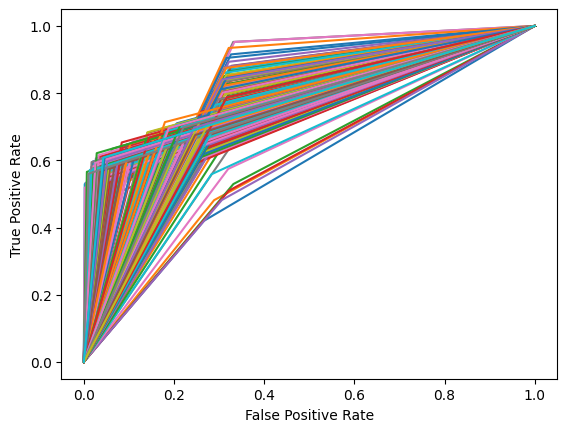

Bad pipe message: %s [b'\x17\x88\x96\x1f\x0b\xd0\xf2G]\xc7R\x9dH\xca"\x96\xdfD \xa5N\xd3?u\x01.\xa1\xd8\xf2!2*\xb1\x8ff\xe7\xaas\x9cw\xfb\xdbj\xa0\xcb+\xe8\xad\x8f\x91^\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff', b'']
Bad pipe message: %s [b'\x87\xa9\xb1\xd9`\x99_\xdbX|T\xb1R\xae\xcb\xeak% :\xce\xc2w\xd3\xe14\t%\xea9\xb6\rB\xf9\x8c\xb6\x1e\x86\x00\xbeG \x99Ep\x1f\xfa\xdd\xe8\r`\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t', b'\x08\x0b\x08\x04\x08\x05\x08']
Bad pipe message: %s [b'\x01\x05\x01\x06\x01']
Bad pipe message: %s [b'\t{\xf7o\xa9\xe3\xcd,\x9b\x9co\x87r\xac\t\x0c\xa2{\x00\x00', b",\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2

In [10]:
###testing
## Accuracy on testing data:
#ACC_count: 1177, ACC:0.7662760615348816
#ACC_count_pos: 510, ACC:0.9444444444444444
#ACC_count_neg: 667, ACC:0.6696787148594378

from sklearn import metrics
from sklearn.metrics import roc_curve
import torch
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
input_size = 1
hidden_size = 10
num_layers = 2
batch_size = 128
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_cls = conv1d(num_classes, input_size, hidden_size, num_layers)
conv_cls = conv_cls.to(device)
for i in range(0, 2000, 5):
    print(i)
    conv_cls.load_state_dict(torch.load(("./checkpoint_360_len/check_point_64_no_drop_{}_epoch.pkl").format(str(i))))
    acc_count_test = 0
    test_len_test = 0
    acc_pos_count = 0
    test_pos_len_test = 0
    acc_neg_count = 0
    test_neg_len_test = 0
    output_curve = []
    gt_curve = []
    test_gt = []
    test_pre = []
    for data_test, label_test in test_loader:
        data_input, label = data_test[:, 0:seq_size].to(device), label_test.to(device) 
        data_input = data_input.reshape((batch_size, input_size, seq_size))
        data_input = data_input.to(torch.float32)
    
        test_output  = conv_cls(data_input)
        acc_count_test += torch.sum(test_output.argmax(dim=1)==label.to(torch.float32).argmax(dim=1))
        test_len_test += len(label)
        for i in range(len(test_output)):
            if label[i].cpu().detach().numpy()[1]==1:
                test_pos_len_test += 1
                test_pre.append(1)
                if test_output[i].argmax()==label[i].argmax(): 
                    acc_pos_count += 1
                    test_gt.append(1)
                else:
                    test_gt.append(0)
            if label[i].cpu().detach().numpy()[1]==0:
                test_neg_len_test += 1
                test_pre.append(0)
                if test_output[i].argmax()==label[i].argmax(): 
                    acc_neg_count += 1
                    test_gt.append(0)
                else:
                    test_gt.append(1)
    plot_roc_curve(test_gt, test_pre)

    fpr, tpr, thresholds = metrics.roc_curve(test_gt, test_pre, pos_label=1)
    aupr = metrics.average_precision_score(test_gt, test_pre)
    print(aupr)
    print(metrics.auc(fpr, tpr))
    print(f'ACC_count: {acc_count_test}, ACC:{acc_count_test/test_len_test}')
    print(f'ACC_count_pos: {acc_pos_count}, ACC:{acc_pos_count/test_pos_len_test}')
    print(f'ACC_count_neg: {acc_neg_count}, ACC:{acc_neg_count/test_neg_len_test}')
